In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [250]:
datapath = '/Users/sidsatya/dev/ailabor/task_classification/data/intermediate_results/classified_tasks_16_dim_intermediate.csv'
classified_data = pd.read_csv(datapath)

In [ ]:
def read_gpt_label(label):
    # label is formatted as a JSON string with 10 key-value pairs
    label = label.replace("'", '"')  # Replace single quotes with double quotes
    label = label.replace('nan', 'null')  # Replace 'nan' with 'null' for JSON compatibility
    if label == 'gpt_label': 
        return {} 
    try:
        label_dict = eval(label)  # Use eval to convert the string to a dictionary
        return label_dict
    except Exception as e:
        print(f"Error parsing label: {e}")
        return {}

classified_data['read_label'] = classified_data['gpt_label'].apply(read_gpt_label)
classified_data['interpersonal'] = classified_data['read_label'].apply(lambda x: 1 if x.get('Interpersonal', 'No') == 'Yes' else 0)
classified_data['routine'] = classified_data['read_label'].apply(lambda x: 1 if x.get('Routine', 'No') == 'Yes' else 0)
classified_data['manual'] = classified_data['read_label'].apply(lambda x: 1 if x.get('Manual', 'No') == 'Yes' else 0)
classified_data['high_codifiable'] = classified_data['read_label'].apply(lambda x: 1 if x.get('High Cod.', 'No') == 'Yes' else 0)

In [252]:
# Group by Task and compute mode and mean for each category
grouped_data = classified_data.groupby('Task').agg({
    'interpersonal': ['count', 'mean', lambda x: x.mode()[0] if not x.mode().empty else 0],
    'routine': ['mean', lambda x: x.mode()[0] if not x.mode().empty else 0],
    'manual': ['mean', lambda x: x.mode()[0] if not x.mode().empty else 0],
    'high_codifiable': ['mean', lambda x: x.mode()[0] if not x.mode().empty else 0]
    }).reset_index()

# collapse the multi-level columns into dimension_mean and dimension_mode
grouped_data.columns = ['Task', 'count', 'interpersonal_mean', 'interpersonal_mode',
                        'routine_mean', 'routine_mode',
                        'manual_mean', 'manual_mode',
                        'high_codifiable_mean', 'high_codifiable_mode']

print(grouped_data.shape)
grouped_data.head(2)

(15201, 10)


,Task,count,interpersonal_mean,interpersonal_mode,routine_mean,routine_mode,manual_mean,manual_mode,high_codifiable_mean,high_codifiable_mode
0,Accept and check containers of mail or parcels...,6,1.0,1,1.0,1,1.0,1,0.5,0
1,"Accept and implement energy schedules, includi...",3,0.0,0,1.0,1,0.0,0,1.0,1


In [253]:
oes_data = pd.read_csv('/Users/sidsatya/dev/ailabor/bls_transformations/output_data/oes_data_filtered_soc_2018.csv')
oes_data_occs = oes_data['soc_2018'].unique()
oes_data_healthcare_occs = oes_data[oes_data['is_healthcare_obs']]['soc_2018'].unique()

/var/folders/y2/820f0d093ps3xgsy472nf3zc0000gn/T/ipykernel_1216/1332690351.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  oes_data = pd.read_csv('/Users/sidsatya/dev/ailabor/bls_transformations/output_data/oes_data_filtered_soc_2018.csv')


In [254]:
print("There are {} unique occupations in OES data.".format(len(oes_data_occs)))
print("There are {} unique occupations in OES healthcare data.".format(len(oes_data_healthcare_occs)))

There are 917 unique occupations in OES data.
There are 610 unique occupations in OES healthcare data.


In [255]:
all_task_datapath = '/Users/sidsatya/dev/ailabor/onet_transformations/intermediate_data/task_data_merged_attributes.csv'
all_task_data = pd.read_csv(all_task_datapath)

In [256]:
# Check how many occs in OES data are present in the task data
unique_occs_in_task_data = all_task_data['O*NET 2018 SOC Code'].unique()
oes_in_task_data = np.isin(oes_data_occs, unique_occs_in_task_data).sum()
print("There are {} occupations in OES data that are also present in the task data.".format(oes_in_task_data))
# Check how many occs in OES healthcare data are present in the task data
oes_healthcare_in_task_data = np.isin(oes_data_healthcare_occs, unique_occs_in_task_data).sum()
print("There are {} occupations in OES healthcare data that are also present in the task data.".format(oes_healthcare_in_task_data))

There are 801 occupations in OES data that are also present in the task data.
There are 514 occupations in OES healthcare data that are also present in the task data.


## Construction of ALM-like Dataset

In [274]:
# datasets 
# oes_data: the OES data with occupations
# oes_data_healthcare: the OES data with healthcare occupations
# all_task_data: the task data with attributes
# grouped_data: the classified task data
oes_data_aggregated_occ = oes_data.groupby(['soc_2018', 'bls_release_year']).agg({'tot_emp': 'sum', 'pct_year_tot_emp': 'sum'}).reset_index()
oes_healthcare_data_aggregated_occ = oes_data[oes_data['is_healthcare_obs']].copy().groupby(['soc_2018', 'bls_release_year']).agg({'tot_emp': 'sum', 'pct_healthcare_tot_emp': 'sum'}).reset_index()

combined_data =  pd.merge(all_task_data, oes_data_aggregated_occ, left_on=['O*NET 2018 SOC Code', 'ONET_release_year'], right_on=['soc_2018', 'bls_release_year'], how='left')
combined_data =  pd.merge(combined_data, grouped_data, on='Task', how = 'left')

combined_data_healthcare = pd.merge(all_task_data, oes_healthcare_data_aggregated_occ, left_on=['O*NET 2018 SOC Code', 'ONET_release_year'], right_on=['soc_2018', 'bls_release_year'], how='left')
combined_data_healthcare = pd.merge(combined_data_healthcare, grouped_data, on='Task', how = 'left')

print("Combined data shape:", combined_data.shape)
print("Combined healthcare data shape:", combined_data_healthcare.shape)

combined_data.head(5)

Combined data shape: (420543, 37)
Combined healthcare data shape: (420543, 37)


,O*NET-SOC Code,O*NET 2010 SOC Code,O*NET 2018 SOC Code,ONET_release_year,Task ID,Task,Task Type,Incumbents Responding,Date,Domain Source,...,pct_year_tot_emp,count,interpersonal_mean,interpersonal_mode,routine_mean,routine_mode,manual_mean,manual_mode,high_codifiable_mean,high_codifiable_mode
0,11-1011.01,11-1011.00,11-1011,2003,NaN,Directs organization charged with administerin...,NaN,NaN,3/2002,Legacy Analyst,...,0.003339,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.666667,1.0
1,11-1011.01,11-1011.00,11-1011,2003,NaN,"Administers, interprets, and explains policies...",NaN,NaN,3/2002,Legacy Analyst,...,0.003339,3.0,1.0,1.0,0.0,0.0,0.0,0.0,1.000000,1.0
2,11-1011.01,11-1011.00,11-1011,2003,NaN,"Develops, plans, organizes, and administers po...",NaN,NaN,3/2002,Legacy Analyst,...,0.003339,3.0,1.0,1.0,0.0,0.0,0.0,0.0,1.000000,1.0
3,11-1011.01,11-1011.00,11-1011,2003,NaN,Directs and coordinates activities of workers ...,NaN,NaN,3/2002,Legacy Analyst,...,0.003339,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,11-1011.01,11-1011.00,11-1011,2003,NaN,Negotiates contracts and agreements with feder...,NaN,NaN,3/2002,Legacy Analyst,...,0.003339,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [ ]:


print("There are {} unique occupations in the combined data for 2003.".format(len(combined_data[combined_data['ONET_release_year'] == 2003]['O*NET 2018 SOC Code'].unique())))
print("There are {} unique occupations in the combined healthcare data for 2003.".format(len(combined_data_healthcare[combined_data_healthcare['ONET_release_year'] == 2003]['O*NET 2018 SOC Code'].unique())))

There are 705 unique occupations in the combined data for 2003.
There are 705 unique occupations in the combined healthcare data for 2003.


In [258]:
print("Checking the coverage of O*NET occupations in the combined data with regards to share of employment in the BLS data:")
combined_data.groupby(['O*NET 2018 SOC Code', 'ONET_release_year']).agg({'pct_year_tot_emp': 'mean'}).reset_index().groupby('ONET_release_year').agg({'pct_year_tot_emp': 'sum'}).reset_index()

Checking the coverage of O*NET occupations in the combined data with regards to share of employment in the BLS data:


,ONET_release_year,pct_year_tot_emp
0,2003,0.932919
1,2004,0.906805
2,2005,0.906960
3,2006,0.916221
4,2007,0.914985
5,2008,0.914418
6,2009,0.956761
7,2010,0.919931
8,2011,0.918225
9,2012,0.969815


In [259]:
print("Checking the coverage of O*NET occupations in the combined data with regards to share of employment in healthcare industries in the BLS data:")
combined_data_healthcare.groupby(['O*NET 2018 SOC Code', 'ONET_release_year']).agg({'pct_healthcare_tot_emp': 'mean'}).reset_index().groupby('ONET_release_year').agg({'pct_healthcare_tot_emp': 'sum'}).reset_index()

Checking the coverage of O*NET occupations in the combined data with regards to share of employment in healthcare industries in the BLS data:


,ONET_release_year,pct_healthcare_tot_emp
0,2003,0.734503
1,2004,0.725008
2,2005,0.724751
3,2006,0.729779
4,2007,0.729567
5,2008,0.728919
6,2009,0.892066
7,2010,0.740632
8,2011,0.739099
9,2012,0.988891


For all occupations that have all task intensities defined and all tasks classified, 
1. Group by occupation-bucket-year and sum the task intensities
2. Multiply each occupation-bucket-year task intensity by the employment share for occupation o in year t across the entire U.S. This is the occupation's contribution to mean task intensity for bucket b in year t. 
3. Then sum across all occupation's contributions to get the mean task input for bucket b in year t

4. Then, for all occupations that we have task input contributions for year == 2003, create an empirical distribution of the occupations' contributions (task index). For example, if the task intensity for occupation o for bucket b in 2003 is 0.5 and the employment share of occupation o in 2003 is 5%, then the empirical dist will return 0.5 with 5% probability. 

5. Finally, for every bucket-year observation (the mean task input for bucket b in year t), compute the percentile of its task-intensity contribution (index) under this empirical distribution. 
6. Then plot! 

In [ ]:
# Drop all observations that do not have a task intensity defined
combined_data_drop_intensities = combined_data.dropna(subset=['task_intensity']).copy()
combined_data_healthcare_drop_intensities = combined_data_healthcare.dropna(subset=['task_intensity']).copy()

del combined_data  # Free up memory by deleting the original combined_data
del combined_data_healthcare  # Free up memory by deleting the original combined_data_healthcare

# Drop all observations that do not have a pct_year_tot_emp defined
combined_data_drop_emp = combined_data_drop_intensities.dropna(subset=['pct_year_tot_emp']).copy()
combined_data_healthcare_drop_emp = combined_data_healthcare_drop_intensities.dropna(subset=['pct_healthcare_tot_emp']).copy()

del combined_data_drop_intensities
del combined_data_healthcare_drop_intensities  # Free up memory by deleting the original combined_data_drop_intensities

# Drop occ-year combinations that have any unclassified tasks
combined_data_drop_emp['task_classified'] = combined_data_drop_emp[['interpersonal_mean', 'routine_mean', 'manual_mean', 'high_codifiable_mean']].notna().all(axis=1)
combined_data_healthcare_drop_emp['task_classified'] = combined_data_healthcare_drop_emp[['interpersonal_mean', 'routine_mean', 'manual_mean', 'high_codifiable_mean']].notna().all(axis=1)

grp_occ_year = combined_data_drop_emp.groupby(['O*NET 2018 SOC Code', 'ONET_release_year']).agg({'task_classified': ['count', 'sum']}).reset_index()
grp_occ_year_healthcare = combined_data_healthcare_drop_emp.groupby(['O*NET 2018 SOC Code', 'ONET_release_year']).agg({'task_classified': ['count', 'sum']}).reset_index()

grp_occ_year.columns = ['O*NET 2018 SOC Code', 'ONET_release_year', 'task_classified_count', 'task_classified_sum']
grp_occ_year_healthcare.columns = ['O*NET 2018 SOC Code', 'ONET_release_year', 'task_classified_count', 'task_classified_sum']


grp_occ_year_valid = grp_occ_year[grp_occ_year['task_classified_sum'] == grp_occ_year['task_classified_count']]
grp_occ_year_valid_healthcare = grp_occ_year_healthcare[grp_occ_year_healthcare['task_classified_sum'] == grp_occ_year_healthcare['task_classified_count']]

combined_data_final = pd.merge(combined_data_drop_emp, grp_occ_year_valid[['O*NET 2018 SOC Code', 'ONET_release_year']], on=['O*NET 2018 SOC Code', 'ONET_release_year'], how='inner')
combined_data_final_healthcare = pd.merge(combined_data_healthcare_drop_emp, grp_occ_year_valid_healthcare[['O*NET 2018 SOC Code', 'ONET_release_year']], on=['O*NET 2018 SOC Code', 'ONET_release_year'], how='inner')

print("There are {} occupations in the full data that we can use for further analysis.".format(len(combined_data_final.groupby('O*NET 2018 SOC Code'))))
print("There are {} occupations in healthcare data that we can use for further analysis.".format(len(combined_data_final_healthcare.groupby('O*NET 2018 SOC Code'))))

combined_data_final.head(5)

There are 398 occupations in the full data that we can use for further analysis.
There are 353 occupations in healthcare data that we can use for further analysis.


,O*NET-SOC Code,O*NET 2010 SOC Code,O*NET 2018 SOC Code,ONET_release_year,Task ID,Task,Task Type,Incumbents Responding,Date,Domain Source,...,count,interpersonal_mean,interpersonal_mode,routine_mean,routine_mode,manual_mean,manual_mode,high_codifiable_mean,high_codifiable_mode,task_classified
0,11-2022.00,11-2022.00,11-2022,2003,1.0,Resolve customer complaints regarding sales an...,Core,81.0,3/2003,Incumbent,...,9.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,True
1,11-2022.00,11-2022.00,11-2022,2003,2.0,Monitor customer preferences to determine focu...,Core,79.0,3/2003,Incumbent,...,9.0,0.666667,1.0,0.0,0.0,0.0,0.0,0.888889,1.0,True
2,11-2022.00,11-2022.00,11-2022,2003,3.0,Direct and coordinate activities involving sal...,Core,79.0,3/2003,Incumbent,...,9.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,True
3,11-2022.00,11-2022.00,11-2022,2003,4.0,Determine price schedules and discount rates.,Core,81.0,3/2003,Incumbent,...,9.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,1.0,True
4,11-2022.00,11-2022.00,11-2022,2003,5.0,Review operational records and reports to proj...,Core,80.0,3/2003,Incumbent,...,9.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,1.0,True


In [277]:
print("There are {} unique occupations in the final combined data for 2003.".format(len(combined_data_drop_emp[combined_data_drop_emp['ONET_release_year'] == 2003]['O*NET 2018 SOC Code'].unique())))

There are 51 unique occupations in the final combined data for 2003.


In [ ]:
# Combine the 'mode' columns into a single 'mode' column for each task type
def combine_modes(row):
    s1 = 'X'
    s2 = 'X'
    s3 = 'X'
    s4 = 'X'
    if row['interpersonal_mode'] == 1:
        s1 = 'I'
    else: 
        s1 = 'P'
    
    if row['routine_mode'] == 1:
        s2 = 'R'
    else:
        s2 = 'NR'
    if row['manual_mode'] == 1:
        s3 = 'M'
    else:
        s3 = 'NM'  
    if row['high_codifiable_mode'] == 1:
        s4 = 'HC'
    else:   
        s4 = 'LC'

    return '-'.join([s1, s2, s3, s4])

def combine_modes_alm(row):
    s1 = 'X'
    s2 = 'X'
    s3 = 'X'
    if row['interpersonal_mode'] == 1:
        s1 = 'I'
    else: 
        s1 = 'P'
    
    if row['routine_mode'] == 1:
        s2 = 'R'
    else:
        s2 = 'NR'
    if row['manual_mode'] == 1:
        s3 = 'M'
    else:
        s3 = 'NM'  

    return '-'.join([s1, s2, s3])

combined_data_final['classification'] = combined_data_final.apply(combine_modes, axis=1)
combined_data_final['classification_alm'] = combined_data_final.apply(combine_modes_alm, axis=1)
combined_data_final_healthcare['classification'] = combined_data_final_healthcare.apply(combine_modes, axis=1)
combined_data_final_healthcare['classification_alm'] = combined_data_final_healthcare.apply(combine_modes_alm, axis=1)

combined_data_final.head(5)


,O*NET-SOC Code,O*NET 2010 SOC Code,O*NET 2018 SOC Code,ONET_release_year,Task ID,Task,Task Type,Incumbents Responding,Date,Domain Source,...,routine_mean,routine_mode,manual_mean,manual_mode,high_codifiable_mean,high_codifiable_mode,task_classified,classification,classification_alm,task_contribution
0,11-2022.00,11-2022.00,11-2022,2003,1.0,Resolve customer complaints regarding sales an...,Core,81.0,3/2003,Incumbent,...,0.0,0.0,0.0,0.0,0.000000,0.0,True,I-NR-NM-LC,I-NR-NM,0.000227
1,11-2022.00,11-2022.00,11-2022,2003,2.0,Monitor customer preferences to determine focu...,Core,79.0,3/2003,Incumbent,...,0.0,0.0,0.0,0.0,0.888889,1.0,True,I-NR-NM-HC,I-NR-NM,0.000264
2,11-2022.00,11-2022.00,11-2022,2003,3.0,Direct and coordinate activities involving sal...,Core,79.0,3/2003,Incumbent,...,0.0,0.0,0.0,0.0,0.000000,0.0,True,I-NR-NM-LC,I-NR-NM,0.000245
3,11-2022.00,11-2022.00,11-2022,2003,4.0,Determine price schedules and discount rates.,Core,81.0,3/2003,Incumbent,...,0.0,0.0,0.0,0.0,1.000000,1.0,True,P-NR-NM-HC,P-NR-NM,0.000206
4,11-2022.00,11-2022.00,11-2022,2003,5.0,Review operational records and reports to proj...,Core,80.0,3/2003,Incumbent,...,0.0,0.0,0.0,0.0,1.000000,1.0,True,P-NR-NM-HC,P-NR-NM,0.000186


: 

In [262]:
# 2. Multiply each occupation-bucket-year task intensity by the employment share for occupation o in year t across the entire U.S. This is the occupation's contribution to mean task intensity for bucket b in year t. 
# 3. Then sum across all occupation's contributions to get the mean task input for bucket b in year t

combined_data_final['task_contribution'] = combined_data_final['pct_year_tot_emp'] * combined_data_final['task_intensity']
combined_data_final_healthcare['task_contribution'] = combined_data_final_healthcare['pct_healthcare_tot_emp'] * combined_data_final_healthcare['task_intensity']

# Group by ONET_release_year and classification and sum the contributions to get the mean task contribution for bucket b in year t
mean_task_contribution_bucket_year = combined_data_final.groupby(['ONET_release_year', 'classification']).agg({'task_contribution': 'sum'}).reset_index()
mean_task_contribution_bucket_year_healthcare = combined_data_final_healthcare.groupby(['ONET_release_year', 'classification']).agg({'task_contribution': 'sum'}).reset_index()

mean_task_contribution_bucket_year.columns = ['ONET_release_year', 'classification', 'mean_task_contribution_bucket_year']
mean_task_contribution_bucket_year_healthcare.columns = ['ONET_release_year', 'classification', 'mean_task_contribution_bucket_year_healthcare']

mean_task_contribution_bucket_year.sort_values(by='mean_task_contribution_bucket_year', ascending=False)
mean_task_contribution_bucket_year_healthcare.sort_values(by='mean_task_contribution_bucket_year_healthcare', ascending=False)

,ONET_release_year,classification,mean_task_contribution_bucket_year_healthcare
32,2005,I-NR-NM-LC,1.420377e-01
56,2006,P-R-M-HC,1.374839e-01
71,2007,P-R-M-HC,1.368127e-01
62,2007,I-NR-NM-LC,1.352330e-01
47,2006,I-NR-NM-LC,1.334803e-01
...,...,...,...
201,2016,P-R-M-LC,1.499381e-06
173,2014,P-R-M-LC,1.321378e-06
243,2019,P-R-M-LC,7.300416e-07
14,2004,I-NR-M-HC,4.190489e-07


In [269]:
# 4. Then, for all occupations that we have task input contributions for year == 2003, create an empirical distribution of the occupations' contributions (task index). 
#   For example, if the task intensity for occupation o for bucket b in 2003 is 0.5 and the employment share of occupation o in 2003 is 5%, then the empirical dist will return 0.5 with 5% probability. 
# 5. Finally, for every bucket-year observation (the mean task input for bucket b in year t), compute the percentile of its task-intensity contribution (index) under this empirical distribution. 

task_contribution_occ_level_2003 = combined_data_final[combined_data_final['ONET_release_year'] == 2003].copy()
task_contribution_occ_level_2003_healthcare = combined_data_final_healthcare[combined_data_final_healthcare['ONET_release_year'] == 2003].copy()

task_contribution_occ_level_2003[['O*NET 2018 SOC Code', 'ONET_release_year', 'classification', 'task_intensity', 'task_contribution']].sort_values(by='task_contribution', ascending=False)
task_contribution_occ_level_2003_healthcare[['O*NET 2018 SOC Code', 'ONET_release_year', 'classification', 'task_intensity', 'task_contribution']].sort_values(by='task_contribution', ascending=False)

mean_task_contribution_bucket_year_2003 = task_contribution_occ_level_2003.groupby(['O*NET 2018 SOC Code', 'classification']).agg({'task_intensity': 'sum', 'pct_year_tot_emp': 'mean'}).reset_index()
mean_task_contribution_bucket_year_2003_healthcare = task_contribution_occ_level_2003_healthcare.groupby(['O*NET 2018 SOC Code', 'classification']).agg({'task_intensity': 'sum', 'pct_healthcare_tot_emp': 'mean'}).reset_index()

mean_task_contribution_bucket_year_2003.columns = ['O*NET 2018 SOC Code', 'classification', 'task_intensity_2003', 'pct_year_tot_emp_2003']
mean_task_contribution_bucket_year_2003_healthcare.columns = ['O*NET 2018 SOC Code', 'classification', 'task_intensity_2003', 'pct_healthcare_tot_emp_2003']

# There are 16 possible classifications based on the 4 dimensions (interpersonal, routine, manual, high codifiable), so should be along the lines of I-R-M-HC, P-NR-NM-LC, etc.
all_possible_classifications = [
    'I-R-M-HC', 'I-R-M-LC', 'I-R-NM-HC', 'I-R-NM-LC',
    'I-NR-M-HC', 'I-NR-M-LC', 'I-NR-NM-HC', 'I-NR-NM-LC',
    'P-R-M-HC', 'P-R-M-LC', 'P-R-NM-HC', 'P-R-NM-LC',
    'P-NR-M-HC', 'P-NR-M-LC', 'P-NR-NM-HC', 'P-NR-NM-LC'
]

# if any soc code does not have a classification, add it with a 0 task intensity, but the same pct_year_tot_emp
new_rows = []
for occ_code in mean_task_contribution_bucket_year_2003['O*NET 2018 SOC Code'].unique():
    for classification in all_possible_classifications:
        if not ((mean_task_contribution_bucket_year_2003['O*NET 2018 SOC Code'] == occ_code) & (mean_task_contribution_bucket_year_2003['classification'] == classification)).any():
            new_row = {
                'O*NET 2018 SOC Code': occ_code,
                'classification': classification,
                'task_intensity_2003': 0,
                'pct_year_tot_emp_2003': mean_task_contribution_bucket_year_2003[mean_task_contribution_bucket_year_2003['O*NET 2018 SOC Code'] == occ_code]['pct_year_tot_emp_2003'].mean()
            }
            new_rows.append(new_row)

if new_rows:
    mean_task_contribution_bucket_year_2003 = pd.concat(
        [mean_task_contribution_bucket_year_2003, pd.DataFrame(new_rows)],
        ignore_index=True
    )

# Do the same for the healthcare data
new_rows = []
for occ_code in mean_task_contribution_bucket_year_2003_healthcare['O*NET 2018 SOC Code'].unique():
    for classification in all_possible_classifications:
        if not ((mean_task_contribution_bucket_year_2003_healthcare['O*NET 2018 SOC Code'] == occ_code) & (mean_task_contribution_bucket_year_2003_healthcare['classification'] == classification)).any():
            new_row = {
                'O*NET 2018 SOC Code': occ_code,
                'classification': classification,
                'task_intensity_2003': 0,
                'pct_healthcare_tot_emp_2003': mean_task_contribution_bucket_year_2003_healthcare[mean_task_contribution_bucket_year_2003_healthcare['O*NET 2018 SOC Code'] == occ_code]['pct_healthcare_tot_emp_2003'].mean()
            }
            new_rows.append(new_row)

if new_rows:
    mean_task_contribution_bucket_year_2003_healthcare = pd.concat(
        [mean_task_contribution_bucket_year_2003_healthcare, pd.DataFrame(new_rows)],
        ignore_index=True
    )

print("There are {} unique occupations in the mean task contribution data for 2003.".format(len(mean_task_contribution_bucket_year_2003['O*NET 2018 SOC Code'].unique())))
print("There are {} unique occupations in the mean task contribution healthcare data for 2003.".format(len(mean_task_contribution_bucket_year_2003_healthcare['O*NET 2018 SOC Code'].unique())))

There are 48 unique occupations in the mean task contribution data for 2003.
There are 43 unique occupations in the mean task contribution healthcare data for 2003.


In [264]:
def weighted_ecdf(values, weights):
    """
    Compute the weighted empirical CDF.
    
    Parameters:
    - values: 1D array of observations (e.g., occupation indices in baseline year).
    - weights: 1D array of non-negative weights (e.g., employment shares), same length as values.
    
    Returns:
    - x_ecdf: sorted values
    - cdf_vals: corresponding cumulative probabilities (sums to 1)
    """
    # Sort values and associated weights
    sorter = np.argsort(values)
    values_sorted = values[sorter]
    weights_sorted = weights[sorter]
    
    # Build cumulative distribution
    cum_weights = np.cumsum(weights_sorted)
    cum_weights /= cum_weights[-1]  # normalize to 1
    
    return values_sorted, cum_weights

def percentile_of(x_new, x_ecdf, cdf_vals):
    """
    Interpolate a new value onto the ECDF to get its percentile.
    
    Parameters:
    - x_new: scalar or array of new observations you want percentiles for.
    - x_ecdf: sorted baseline values from weighted_ecdf.
    - cdf_vals: ECDF probabilities corresponding to x_ecdf.
    
    Returns:
    - p: percentile(s) between 0 and 1 (or array of same shape as x_new).
    """
    return np.interp(x_new, x_ecdf, cdf_vals, left=0.0, right=1.0)

# Compute ECDF for each classification dimension in 2003
ecdf_results = {}
ecdf_results_healthcare = {}
for classification in all_possible_classifications:
    # Filter for the current classification
    filtered_data = mean_task_contribution_bucket_year_2003[mean_task_contribution_bucket_year_2003['classification'] == classification]
    filtered_data_healthcare = mean_task_contribution_bucket_year_2003_healthcare[mean_task_contribution_bucket_year_2003_healthcare['classification'] == classification]
    
    # Get values and weights
    values = filtered_data['task_intensity_2003'].values
    weights = filtered_data['pct_year_tot_emp_2003'].values

    values_healthcare = filtered_data_healthcare['task_intensity_2003'].values
    weights_healthcare = filtered_data_healthcare['pct_healthcare_tot_emp_2003'].values
    
    # Compute ECDF
    x_ecdf, cdf_vals = weighted_ecdf(values, weights)
    x_ecdf_healthcare, cdf_vals_healthcare = weighted_ecdf(values_healthcare, weights_healthcare)
    
    # Store results
    ecdf_results[classification] = (x_ecdf, cdf_vals)
    ecdf_results_healthcare[classification] = (x_ecdf_healthcare, cdf_vals_healthcare)

print("Full CDF: ", ecdf_results) 
print("Healthcare CDF: ", ecdf_results_healthcare)

Full CDF:  {'I-R-M-HC': (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.02179154, 0.05892702,
       0.06665561, 0.09436314, 0.09967125, 0.13626336, 0.19575611,
       0.21027846, 0.23889855, 0.2681644 ]), array([0.00889262, 0.02109264, 0.0307032 , 0.03792445, 0.0548275 ,
       0.06981605, 0.0776916 , 0.07884084, 0.08406165, 0.08964143,
       0.10352153, 0.10870101, 0.11974798, 0.1245636 , 0.17474082,
       0.18493552, 0.19223182, 0.19346428, 0.19588351, 0.19709258,
       0.20501435, 0.21054681, 0.22947912, 0.24371493, 0.30

In [265]:
# For each bucket-year observation, compute the percentile of its task-intensity contribution under the empirical distribution
def compute_percentile_for_bucket_year(row, ecdf_results, is_healthcare=False):
    if is_healthcare:
        classification = row['classification']
        task_intensity = row['mean_task_contribution_bucket_year_healthcare']
    else:
        classification = row['classification']
        task_intensity = row['mean_task_contribution_bucket_year']

    if classification in ecdf_results:
        x_ecdf, cdf_vals = ecdf_results[classification]
        return percentile_of(task_intensity, x_ecdf, cdf_vals)
    else:
        print(classification, "not found in ECDF results", is_healthcare)
        return np.nan  # If classification not found

mean_task_contribution_bucket_year['percentile'] = mean_task_contribution_bucket_year.apply(compute_percentile_for_bucket_year, axis=1, ecdf_results=ecdf_results)
mean_task_contribution_bucket_year_healthcare['percentile'] = mean_task_contribution_bucket_year_healthcare.apply(compute_percentile_for_bucket_year, axis=1, ecdf_results=ecdf_results_healthcare, is_healthcare=True)

mean_task_contribution_bucket_year

,ONET_release_year,classification,mean_task_contribution_bucket_year,percentile
0,2003,I-NR-M-LC,0.004316,0.658584
1,2003,I-NR-NM-HC,0.005097,0.562769
2,2003,I-NR-NM-LC,0.033220,0.123504
3,2003,I-R-M-HC,0.002808,0.891522
4,2003,I-R-M-LC,0.006240,0.500729
...,...,...,...,...
315,2024,P-NR-NM-HC,0.012423,0.587300
316,2024,P-NR-NM-LC,0.001223,0.676419
317,2024,P-R-M-HC,0.019174,0.304310
318,2024,P-R-M-LC,0.000593,0.988995


Full Employment Shares Viz

/var/folders/y2/820f0d093ps3xgsy472nf3zc0000gn/T/ipykernel_1216/2172922756.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', num_classes)


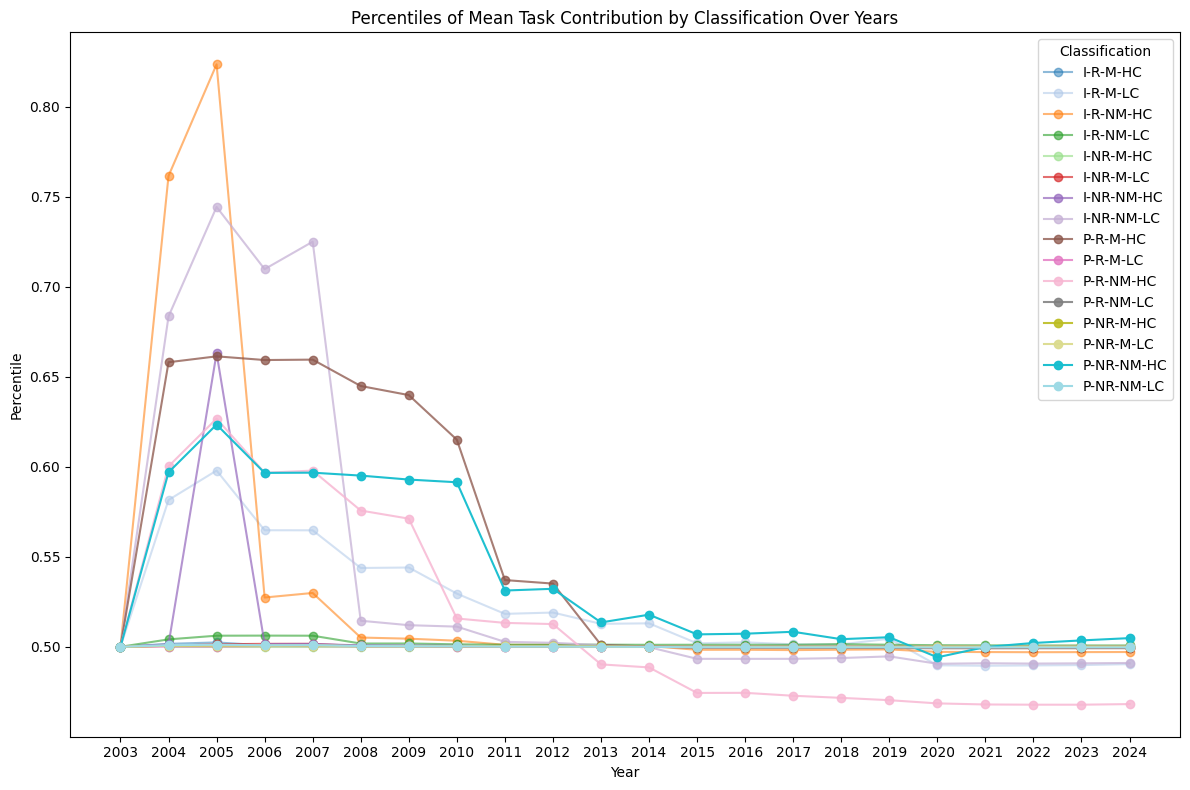

In [266]:
# after you already have `mean_task_contribution_bucket_year` with `percentile` column
# Compute percentile relative to the 2003 baseline
mean_task_contribution_bucket_year_2003['contribution'] = mean_task_contribution_bucket_year_2003['task_intensity_2003'] * mean_task_contribution_bucket_year_2003['pct_year_tot_emp_2003']
mean_task_contribution_bucket_year_2003_grp = mean_task_contribution_bucket_year_2003.groupby('classification').agg({'contribution': 'sum'}).reset_index()
mean_task_contribution_bucket_year_2003_grp.columns = ['classification', 'mean_task_contribution_bucket_year']
mean_task_contribution_bucket_year_2003_grp['percentile'] = mean_task_contribution_bucket_year_2003_grp.apply(compute_percentile_for_bucket_year, axis=1, ecdf_results=ecdf_results)

baseline = mean_task_contribution_bucket_year_2003_grp

# mapping {classification: baseline percentile}
base_p = dict(zip(baseline['classification'], baseline['percentile']))

mean_task_contribution_bucket_year['pct_centered'] = (
    mean_task_contribution_bucket_year
        .apply(lambda r: r['percentile'] - base_p[r['classification']] + 0.5, axis=1)
)


# Plot the percentiles for each classification over the years
plt.figure(figsize=(12, 8))
import matplotlib.cm as cm

num_classes = len(all_possible_classifications)
colors = cm.get_cmap('tab20', num_classes)

for idx, classification in enumerate(all_possible_classifications):
    subset = mean_task_contribution_bucket_year[mean_task_contribution_bucket_year['classification'] == classification]
    # Vary alpha (opacity) between 0.5 and 1.0 for visual distinction
    alpha = 0.5 + 0.5 * (idx / max(1, num_classes - 1))
    plt.plot(
        subset['ONET_release_year'],
        subset['pct_centered'],
        marker='o',
        label=classification,
        color=colors(idx),
        alpha=alpha
    )
plt.title('Percentiles of Mean Task Contribution by Classification Over Years')
plt.xlabel('Year')
plt.ylabel('Percentile')
plt.xticks(subset['ONET_release_year'].unique())
plt.legend(title='Classification')
plt.tight_layout()
plt.show()

Healthcare Industries Viz

/var/folders/y2/820f0d093ps3xgsy472nf3zc0000gn/T/ipykernel_1216/3320627167.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', num_classes)


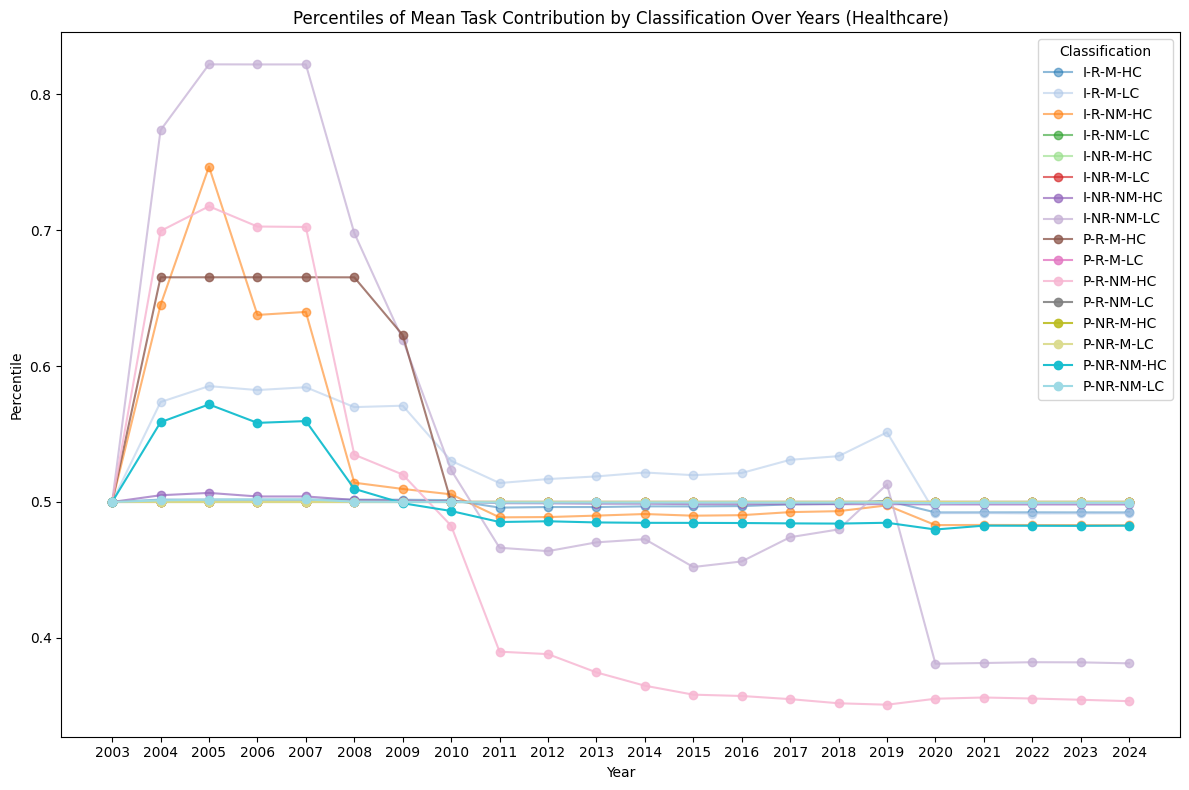

In [267]:
# Compute percentile relative to the 2003 baseline for healthcare data
mean_task_contribution_bucket_year_2003_healthcare['contribution'] = (
    mean_task_contribution_bucket_year_2003_healthcare['task_intensity_2003'] *
    mean_task_contribution_bucket_year_2003_healthcare['pct_healthcare_tot_emp_2003']
)
mean_task_contribution_bucket_year_2003_grp_healthcare = (
    mean_task_contribution_bucket_year_2003_healthcare
    .groupby('classification')
    .agg({'contribution': 'sum'})
    .reset_index()
)
mean_task_contribution_bucket_year_2003_grp_healthcare.columns = ['classification', 'mean_task_contribution_bucket_year']
mean_task_contribution_bucket_year_2003_grp_healthcare['percentile'] = mean_task_contribution_bucket_year_2003_grp_healthcare.apply(
    compute_percentile_for_bucket_year, axis=1, ecdf_results=ecdf_results_healthcare
)

baseline_healthcare = mean_task_contribution_bucket_year_2003_grp_healthcare
base_p_healthcare = dict(zip(baseline_healthcare['classification'], baseline_healthcare['percentile']))

mean_task_contribution_bucket_year_healthcare['pct_centered'] = (
    mean_task_contribution_bucket_year_healthcare
        .apply(lambda r: r['percentile'] - base_p_healthcare[r['classification']] + 0.5, axis=1)
)

# Plot the percentiles for each classification over the years (healthcare)
plt.figure(figsize=(12, 8))
import matplotlib.cm as cm

num_classes = len(all_possible_classifications)
colors = cm.get_cmap('tab20', num_classes)

for idx, classification in enumerate(all_possible_classifications):
    subset = mean_task_contribution_bucket_year_healthcare[
        mean_task_contribution_bucket_year_healthcare['classification'] == classification
    ]
    alpha = 0.5 + 0.5 * (idx / max(1, num_classes - 1))
    plt.plot(
        subset['ONET_release_year'],
        subset['pct_centered'],
        marker='o',
        label=classification,
        color=colors(idx),
        alpha=alpha
    )
plt.title('Percentiles of Mean Task Contribution by Classification Over Years (Healthcare)')
plt.xlabel('Year')
plt.ylabel('Percentile')
plt.xticks(subset['ONET_release_year'].unique())
plt.legend(title='Classification')
plt.tight_layout()
plt.show()

/var/folders/y2/820f0d093ps3xgsy472nf3zc0000gn/T/ipykernel_1216/1705900181.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', num_classes)


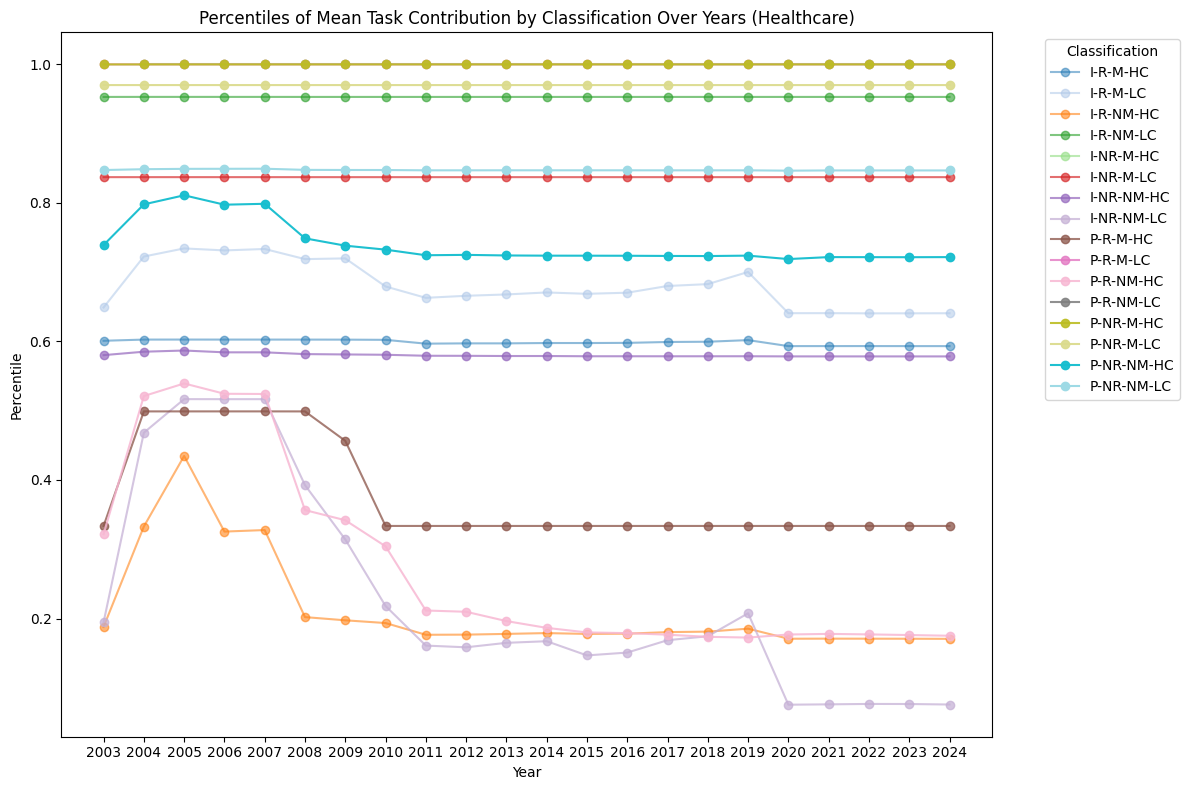

In [268]:
# Plot the percentiles for each classification over the years (healthcare)
plt.figure(figsize=(12, 8))
import matplotlib.cm as cm

num_classes = len(all_possible_classifications)
colors = cm.get_cmap('tab20', num_classes)

for idx, classification in enumerate(all_possible_classifications):
    subset = mean_task_contribution_bucket_year_healthcare[
        mean_task_contribution_bucket_year_healthcare['classification'] == classification
    ]
    alpha = 0.5 + 0.5 * (idx / max(1, num_classes - 1))
    plt.plot(
        subset['ONET_release_year'],
        subset['percentile'],
        marker='o',
        label=classification,
        color=colors(idx),
        alpha=alpha
    )
plt.title('Percentiles of Mean Task Contribution by Classification Over Years (Healthcare)')
plt.xlabel('Year')
plt.ylabel('Percentile')
plt.xticks(subset['ONET_release_year'].unique())
plt.legend(title='Classification', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Save tasks that fall under all classifications

In [192]:
all_possible_classifications = [
    'I-R-M-HC', 'I-R-M-LC', 'I-R-NM-HC', 'I-R-NM-LC',
    'I-NR-M-HC', 'I-NR-M-LC', 'I-NR-NM-HC', 'I-NR-NM-LC',
    'P-R-M-HC', 'P-R-M-LC', 'P-R-NM-HC', 'P-R-NM-LC',
    'P-NR-M-HC', 'P-NR-M-LC', 'P-NR-NM-HC', 'P-NR-NM-LC'
]
for cat in all_possible_classifications:
    combined_data_final[combined_data_final['classification'] == cat].groupby(['Task']).agg('count').reset_index()['Task'].to_csv('/Users/sidsatya/dev/ailabor/results/alm_classification_results/{}_tasks.csv'.format(cat), index=False)